# MSML651 Project: Predicting Sentiment of Tweets Using the Sentiment140 Dataset

- Name: Aditya Patkar
- UID: 119390818

# RoBERTa

In [1]:
#install required libraries
!pip install awscli boto3 wandb transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: docutils
    Found existing installation: docutils 0.18.1
    Uninstalling docutils-0.18.1:
      Successfully

## Imports and config

In [2]:
#Set up required secrets
import os
access_key = os.environ.get('AWS_ACCESS_KEY_ID')
secret_key = os.environ.get('AWS_SECRET_ACCESS_KEY')
wandb_key = os.environ.get('WANDB_API_KEY')
huggingface_key = os.environ.get('HUGGINGFACE_KEY')

In [5]:
#WandB config
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
#wandb.login(relogin=True, key=wandb_key) #uncomment this line if you are running this code for the first time
#resume previous run
#run = wandb.init(id="9toau80e", resume="must", project="msml651-sentiment-analysis", entity="apatkar")

run = wandb.init(project="msml651-sentiment-analysis", entity="apatkar", name="Roberta", config={"bs": 12} )

wandb: Currently logged in as: apatkar. Use `wandb login --relogin` to force relogin


In [6]:
#AWS config
!aws configure set aws_access_key_id $access_key
!aws configure set aws_secret_access_key $secret_key
!aws configure set default.region us-east-1

In [7]:
#Necessary imports
import pandas as pd
import nltk
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import tensorflow as tf

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import TFTrainer, TFTrainingArguments
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

In [8]:
#Get data from AWS
!aws s3 cp s3://msml651/sentiment140_clean_no_stopwords.parquet .


download: s3://msml651/sentiment140_clean_no_stopwords.parquet to ./sentiment140_clean_no_stopwords.parquet


In [9]:
#model and data configuration
config = {'train_size':0.8,
          'test_size':0.2,
          'dropout':0.2,
          'batch_size':16,
          'epochs':5,
          'learning_rate': 1e-5,
          'decay_steps': 10000,
          'end_learning_rate': 1e-7}
wandb.config.update(config)

## Data Preprocessing

In [10]:
#read the data
df = pd.read_parquet("/content/sentiment140_clean_no_stopwords.parquet")
df.head()

,target,tweet_id,date,query_flag,user_name,tweet,post_clean_length,pre_clean_length,pre_clean_words,post_clean_words,tweet_without_stopwords
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww that s a bummer you shoulda got david car...,44,115,19,8,awww bummer shoulda got david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can t update his facebook by ...,69,111,21,11,upset update facebook texting might cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...,49,89,18,9,dived many times ball managed save rest go bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,32,47,10,6,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no it s not behaving at all i m mad why am i h...,16,111,21,3,behaving mad see


In [11]:
#train test split
train_texts, test_texts, train_labels, test_labels = train_test_split(df['tweet'].tolist(),
                                                                      df['target'].tolist(),
                                                                      test_size=config['test_size'],
                                                                      stratify=df['target'])

In [12]:
#create encodings using tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='tf')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors='tf')

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [13]:
#standardize labels
train_labels = np.array([1 if i == 4 else i for i in train_labels])
test_labels = np.array([1 if i == 4 else i for i in test_labels])

In [14]:
#convert to tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))

In [15]:
#batch the data
train_dataset = train_dataset.shuffle(10000).batch(config['batch_size'])
test_dataset = test_dataset.batch(config['batch_size'])

## Model

In [ ]:
#initialize model from huggingface
model = TFAutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

In [ ]:
#initialize a checkpoint for saving the model
checkpoint = ModelCheckpoint('model_weights.h5',
                             save_weights_only=True,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True)

In [19]:
#LR Scheduler
learning_rate_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    config['learning_rate'],
    config['decay_steps'],
    end_learning_rate=config['end_learning_rate'],
    power=1.0,
    cycle=False,
    name=None
)

In [38]:
#set up optimizer, loss and metric to be tracked
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_scheduler)
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.BinaryAccuracy('accuracy')


## Training

In [ ]:
#compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
#check the summary
print(model.summary())

In [ ]:
#train the model
history = model.fit(train_dataset,
          epochs=config['epochs'],
          batch_size=config['batch_size'],
          validation_data=test_dataset,
          verbose=1,
          callbacks=[WandbMetricsLogger(log_freq="batch"), checkpoint]
)

Epoch 1/5
80000/80000 [==============================] - 9197s 114ms/step - loss: 0.4170 - accuracy: 0.8309 - val_loss: 0.3853 - val_accuracy: 0.8430
Epoch 2/5
80000/80000 [==============================] - 9158s 114ms/step - loss: 0.4040 - accuracy: 0.8365 - val_loss: 0.3796 - val_accuracy: 0.8454
Epoch 3/5
80000/80000 [==============================] - 9212s 115ms/step - loss: 0.3985 - accuracy: 0.8386 - val_loss: 0.3742 - val_accuracy: 0.8462
Epoch 4/5
80000/80000 [==============================] - 9222s 115ms/step - loss: 0.3952 - accuracy: 0.8405 - val_loss: 0.3789 - val_accuracy: 0.8479
Epoch 5/5
80000/80000 [==============================] - 9242s 116ms/step - loss: 0.3908 - accuracy: 0.8418 - val_loss: 0.3903 - val_accuracy: 0.8492


In [ ]:
#save history
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
#save model to WandB
artifact = wandb.Artifact('model', type='model')
artifact.add_file('model_weights.h5')
artifact.add_file('history.pkl')
wandb.log_artifact(artifact)

<Artifact model>

##Evaluation

In [16]:
#load saved model from WandB

artifact = run.use_artifact('apatkar/msml651-sentiment-analysis/model:latest', type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact model:latest, 475.76MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:21.8


In [20]:
#LR Scheduler
learning_rate_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    config['learning_rate'],
    config['decay_steps'],
    end_learning_rate=config['end_learning_rate'],
    power=1.0,
    cycle=False,
    name=None
)

optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_scheduler)
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.BinaryAccuracy('accuracy')


In [21]:
model = TFAutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=1)
model.load_weights('/content/artifacts/model:v2/model_weights.h5')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [22]:
#find accuracy and loss on test data
score = model.evaluate(test_dataset, batch_size = config['batch_size'])
print("Test loss:", score[0])
print("Test accuracy:", score[1])

20000/20000 [==============================] - 759s 38ms/step - loss: 0.3703 - accuracy: 0.8480
Test loss: 0.3703194260597229
Test accuracy: 0.8479718565940857


In [23]:
#get precision, recall and f1
y_pred = model.predict(test_dataset, batch_size=1024, verbose=1)
y_pred_lst = [[0] if i[0] < 0.5 else [1] for i in y_pred[0]]
y_pred_lst = np.array(y_pred_lst).tolist()
test_labels = np.array(test_labels).tolist()
precision = precision_score(test_labels, y_pred_lst, average='binary')
recall = recall_score(test_labels, y_pred_lst, average='binary')
f1 = f1_score(test_labels, y_pred_lst, average='binary')

print(precision, recall, f1)

20000/20000 [==============================] - 728s 36ms/step
0.8637471334957958 0.8262875 0.8446021701840856


In [24]:
def test_thresholds(y_test, y_pred_og, thresholds=[i*0.01 for i in range(35,80,5)]):
  """
  This function tests different thresholds to find the best F1 score
  """
  best_threshold = thresholds[0]
  best_f1 = 0
  best_y_pred = [[0] if i[0] < thresholds[0] else [1] for i in y_pred_og[0]]
  for threshold in thresholds:
    y_pred = [[0] if i[0] < threshold else [1] for i in y_pred_og[0]]
    f1 = f1_score(y_test, y_pred, average='binary')
    if f1 > best_f1:
      best_f1 = f1
      best_threshold = threshold
      best_y_pred = y_pred
  return best_threshold, best_f1, best_y_pred





In [25]:
#get the best threshold, calculate precision, recall, f1 and accuracy
best_threshold, best_f1, best_y_pred = test_thresholds(test_labels, y_pred)

print(f"Best threshold:{best_threshold}")
print(f"Best f1:{best_f1}")
precision = precision_score(test_labels, best_y_pred, average='binary')
recall = recall_score(test_labels, best_y_pred, average='binary')
f1 = f1_score(test_labels, best_y_pred, average='binary')
accuracy = accuracy_score(test_labels, best_y_pred)
print(precision, recall,f1, accuracy)

Best threshold:0.4
Best f1:0.8503710592165237
0.832788103198284 0.8687125 0.8503710592165237 0.84714375


##Save Model to HF and Log Metrics

In [27]:
#save model and tokenizer to HF
model.save_pretrained('TweeBERTa', push_to_hub=True, token=huggingface_key)
tokenizer.save_pretrained('TweeBERTa', push_to_hub=True, token=huggingface_key)

('TweeBERTa/tokenizer_config.json',
 'TweeBERTa/special_tokens_map.json',
 'TweeBERTa/vocab.json',
 'TweeBERTa/merges.txt',
 'TweeBERTa/added_tokens.json',
 'TweeBERTa/tokenizer.json')

In [28]:
#log metrics
wandb.log({'accuracy': accuracy, 'loss':score[0], 'precision':precision, 'recall':recall, 'f1':f1, 'threshold':best_threshold})

## Visualization

In [29]:
#load history
with open('/content/artifacts/model:v2/history.pkl', 'rb') as f:
    history = pickle.load(f)

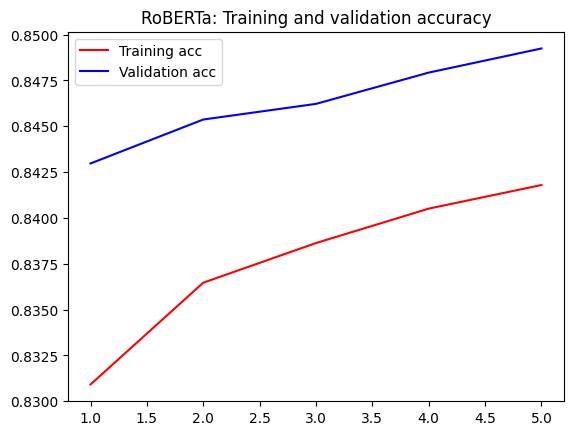

In [33]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc,label = 'Training acc', color='red')
plt.plot(epochs, val_acc, label = 'Validation acc', color='blue')
plt.title('RoBERTa: Training and validation accuracy')
plt.legend()
image = plt
wandb.log({"Roberta Accuracy": wandb.Image(image)})

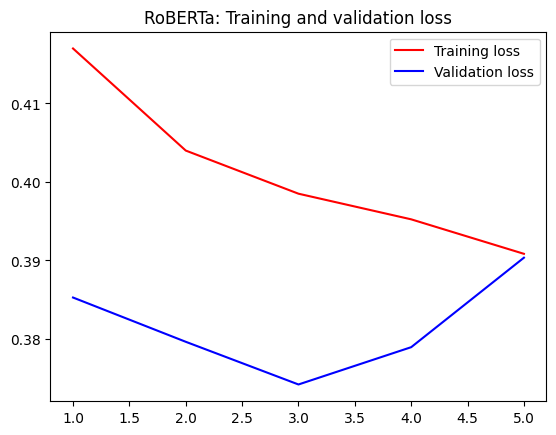

In [34]:
plt.plot(epochs, loss,label = 'Training loss', color='red')
plt.plot(epochs, val_loss, label = 'Validation loss', color='blue')
plt.title('RoBERTa: Training and validation loss')
plt.legend()
image = plt
wandb.log({"Roberta Loss": wandb.Image(image)})

In [35]:
wandb.finish()

accuracy,▁
f1,▁
loss,▁
precision,▁
recall,▁
threshold,▁
accuracy,0.84714
batch/accuracy,0.84179
batch/batch_step,399999
batch/learning_rate,0.0
batch/loss,0.39083


## Prediction using HF hosted model

In [37]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="adityapatkar/TweeBERTa")
pipe("Bad")


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at adityapatkar/TweeBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


[{'label': 'LABEL_0', 'score': 0.5166779160499573}]